In [1]:
import pandas as pd
import numpy as np
import pylab

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
sns.set(color_codes=True)

from datetime import datetime

import scipy.stats as st
import statsmodels.api as sm

pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Importaton des données issues du nettoyage
df_principal = pd.read_csv('Export/export_nettoyage.csv', parse_dates=[6], low_memory=False)

# Je supprime les lignes comprenant des NaN pour les catégories et les âges
df_principal['product_cat'] = df_principal['product_cat'].fillna(3)
df_principal = df_principal.loc[(df_principal.product_cat != 3)]
df_principal['client_age'] = df_principal['client_age'].fillna(1000)
df_principal = df_principal.loc[(df_principal.client_age != 1000)]

# Je renomme la colonne catégorie pour plus de lisibilité
df_principal = df_principal.rename(columns={'product_cat': 'Catégories'})

# J'exclu les 'gros clients' de mon analyse
df_principal.drop(df_principal[df_principal['Gros_client']=='Yes'].index, inplace=True)

# Je créé deux liste pour plus de simplicité dans mon analyse
tranches_ages = df_principal['client_tranche_age'].unique() # Liste des 4 tranches d'âge
cats = df_principal['Catégories'].unique() # Liste des 3 catégories

# Je déclare une fonction qui me permettra de calculer le η2
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## 1. Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
Nous émettons deux hypothèse de travail pour établir s'il existe, ou non, une corrélation entre ces deux variables :
- $H_0$ : Les deux variables sont indépendantes, elles ne sont pas corrélées.  
- $H_1$ : Les deux variables ne sont pas indépendantes, elles sont corrélées.

,Ventes Femmes,Vente Hommes,Total
Catégories,,,
0,101206,94064,195270
1,52993,48061,101054
2,8122,7634,15756
Total,162321,149759,312080


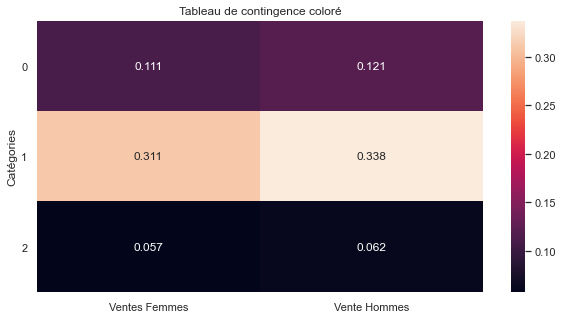

Le χ2 est de 11.41
La P-value est de 0.003
Le degré de liberté est de 2


In [3]:
# Je réalise un tableau de contingence
tab_cont = pd.crosstab(df_principal['Catégories'].astype('int32'), df_principal.client_sex, margins=True, margins_name='Total')
tab_cont.columns = ['Ventes Femmes','Vente Hommes','Total']

display(tab_cont)

# Que j'affiche sous forme de tableau coloré
tx = tab_cont.loc[:,["Total"]]
ty = tab_cont.loc[["Total"],:]
n = len(df_principal)
indep = tx.dot(ty) / n
c = tab_cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

plt.figure(figsize=(10,5))
sns.heatmap(table.iloc[:-1,:-1], annot=True, fmt=".3f")
plt.title("Tableau de contingence coloré")
plt.savefig('Graphiques/khi2_sex_client_cat_produit.png') # J'enregistre le graphique
plt.yticks(rotation=0)
plt.show()

# Je calcule le Khi2
chi2, p, dof, expected = st.chi2_contingency(tab_cont.iloc[:-1,:-1])

print(f'Le χ2 est de {chi2:.2f}')
print(f'La P-value est de {p:.3f}')
print(f'Le degré de liberté est de {dof}')



La comparaison entre notre χ2 calculé et le χ2 théorique nous permet de trancher entre les deux hypothèses.   
Pour α=5% : Le sexe des clients a une incidence sur la catégorie des produits achetés. C'est l'hypothèse alternative ($H_1$) qui l'emporte.  

Source utilisée : https://archimede.mat.ulaval.ca/stt1920/STT-1920-Loi-du-khi-deux.pdf et http://aristeri.com/pages/statistiques/test_khi2/fiche_khi2.pdf

## 2. Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?

η2 est égale à 0.10.


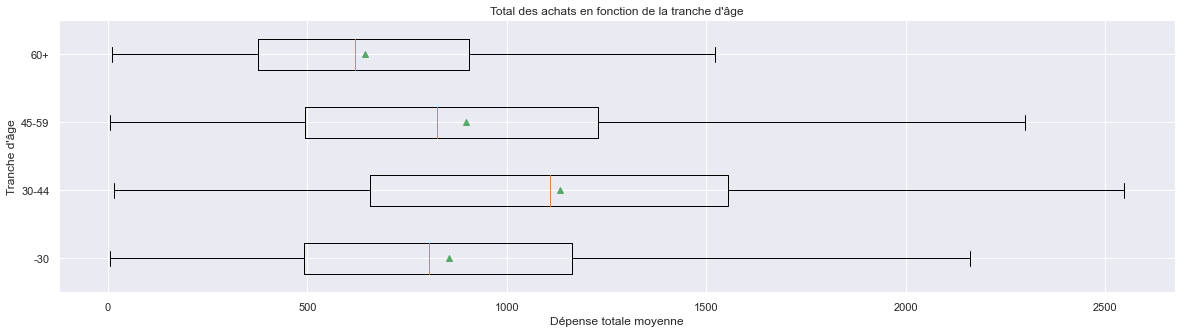

In [4]:
# J'agrège les dépenses totales par âge des clients
agg_prix_par_id = df_principal[['client_id', 'product_price']]
client_age = df_principal[['client_id', 'client_tranche_age']]
agg_prix_par_id = agg_prix_par_id.groupby(['client_id']).agg({'product_price':'sum'}).reset_index()
agg_prix_par_id.columns = ['client_id', 'Dépenses totales']
agg_prix_par_age = pd.merge(agg_prix_par_id, client_age, on='client_id')
agg_prix_par_age = agg_prix_par_age[['Dépenses totales','client_tranche_age']]

# On classe les dépenses dans les tranche d'age
tranche_age_depenses = {
    tranche_age: agg_prix_par_age.loc[agg_prix_par_age.client_tranche_age == tranche_age, 'Dépenses totales'] for tranche_age in tranches_ages
    }

# On calcul ETA2
print(f'η2 est égale à {eta_squared(agg_prix_par_age["client_tranche_age"], agg_prix_par_age["Dépenses totales"]):.2f}.')

# On affiche la distribution de la fréquence d'achat en fonction de la tranche d'âge
plt.figure(figsize=(20,5))
plt.boxplot([
    tranche_age_depenses['-30'],
    tranche_age_depenses['30-44'],
    tranche_age_depenses['45-59'],
    tranche_age_depenses['60+']
], vert=False, showmeans=True, showfliers=False)
plt.title("Total des achats en fonction de la tranche d'âge")
plt.xlabel("Dépense totale moyenne")
plt.ylabel("Tranche d'âge")
plt.yticks([1,2,3,4], ['-30', '30-44', '45-59', '60+'])
plt.savefig('Graphiques/anova_age_client_montant_total.png') # J'enregistre le graphique
plt.show()


## 3. Y a-t-il une corrélation entre l'âge des clients et la fréquence d'achat mensuelle ?

η2 est égale à 0.25.


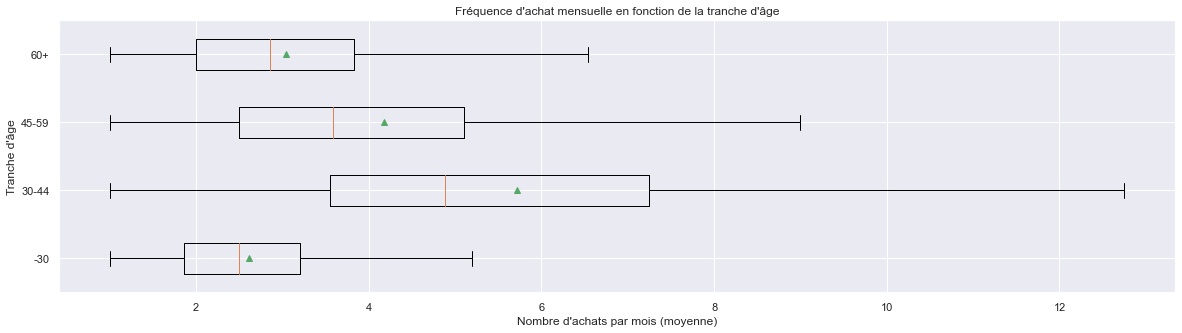

In [5]:
df_temp1 = df_principal[['client_id', 'client_tranche_age', 'transaction_month', 'product_id']]

# on met les ages de coté
client_tranche_age = df_temp1[['client_id', 'client_tranche_age']].drop_duplicates()
# on aggrège les achats
nb_achats = df_temp1[['client_id', 'transaction_month', 'product_id']]
# on compte le nb d'achats par mois
nb_achats = nb_achats.groupby(['client_id', 'transaction_month']).agg({'product_id': 'count'}).reset_index()
nb_achats.columns = ['client_id', 'transaction_month', 'total_achat']
# on fait la moyenne du nombre d'achat mensuel
nb_achats = nb_achats.groupby('client_id').agg({'total_achat': 'mean'}).reset_index()
nb_achats.columns = ['client_id', 'nb_achat_mois_moy']
# on fusionne les deux
agg_nb_achat_par_age = pd.merge(client_tranche_age, nb_achats, on='client_id')

# On classe les client dans les tranche d'age en fonction de leur fréquence d'achat
tranche_age_nb_achat_mois = {
    tranche_age: agg_nb_achat_par_age.loc[agg_nb_achat_par_age.client_tranche_age == tranche_age, 'nb_achat_mois_moy'] for tranche_age in tranches_ages
    }

# On calcul ETA2
print(f'η2 est égale à {eta_squared(agg_nb_achat_par_age["client_tranche_age"], agg_nb_achat_par_age["nb_achat_mois_moy"]):.2f}.')

# On affiche la distribution de la fréquence d'achat en fonction de la tranche d'âge
plt.figure(figsize=(20,5))
plt.boxplot([
    tranche_age_nb_achat_mois['-30'],
    tranche_age_nb_achat_mois['30-44'],
    tranche_age_nb_achat_mois['45-59'],
    tranche_age_nb_achat_mois['60+']
], vert=False, showmeans=True, showfliers=False)
plt.title("Fréquence d'achat mensuelle en fonction de la tranche d'âge")
plt.xlabel("Nombre d'achats par mois (moyenne)")
plt.ylabel("Tranche d'âge")
plt.yticks([1,2,3,4], ['-30', '30-44', '45-59', '60+'])
plt.savefig('Graphiques/anova_age_client_frequence_achat.png') # J'enregistre le graphique
plt.show()


## 4. Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d'article) ?

η2 est égale à 0.22.


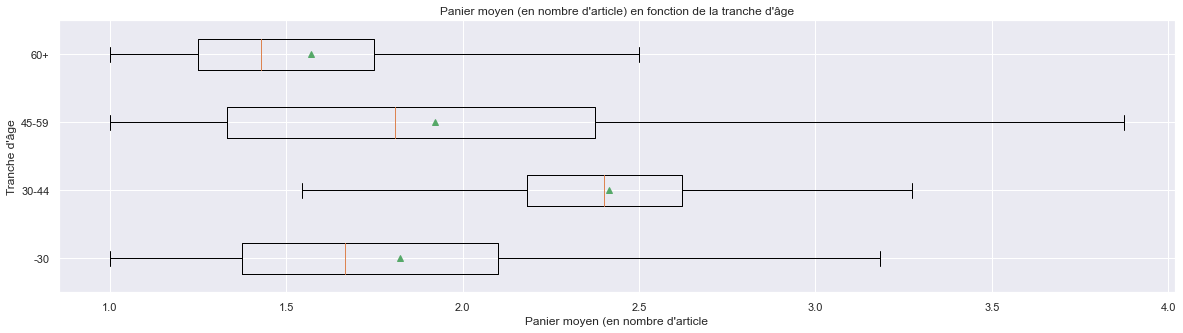

In [6]:
# On calcul le panier moyen en nombre d'article par age client
agg_panier_moy_par_age = df_principal[['client_id', 'client_tranche_age', 'transaction_sess_id', 'product_id']]
agg_panier_moy_par_age = agg_panier_moy_par_age.groupby(['client_id','client_tranche_age','transaction_sess_id']).agg({'product_id':'count'}).reset_index()
agg_panier_moy_par_age = agg_panier_moy_par_age.groupby(['client_id','client_tranche_age']).agg({'product_id':'mean'}).reset_index()
agg_panier_moy_par_age = agg_panier_moy_par_age[['client_tranche_age','product_id']]
agg_panier_moy_par_age.columns = ['client_tranche_age', 'nb_produit_moy']

# On classe les paniers moyens dans les tranche d'age
tranche_age_panier_moy = {
    tranche_age: agg_panier_moy_par_age.loc[agg_panier_moy_par_age.client_tranche_age == tranche_age, 'nb_produit_moy'] for tranche_age in tranches_ages
    }

# On calcul ETA2
print(f'η2 est égale à {eta_squared(agg_panier_moy_par_age["client_tranche_age"], agg_panier_moy_par_age["nb_produit_moy"]):.2f}.')

# On affiche la distribution de la fréquence d'achat en fonction de la tranche d'âge
plt.figure(figsize=(20,5))
plt.boxplot([
    tranche_age_panier_moy['-30'],
    tranche_age_panier_moy['30-44'],
    tranche_age_panier_moy['45-59'],
    tranche_age_panier_moy['60+']
], vert=False, showmeans=True, showfliers=False)
plt.title("Panier moyen (en nombre d'article) en fonction de la tranche d'âge")
plt.xlabel("Panier moyen (en nombre d'article")
plt.ylabel("Tranche d'âge")
plt.yticks([1,2,3,4], ['-30', '30-44', '45-59', '60+'])
plt.savefig('Graphiques/anova_age_client_panier_moy.png') # J'enregistre le graphique
plt.show()

## 5. Y a-t-il une corrélation entre l'âge des clients et les catégories des produits achetés ?
Nous émettons deux hypothèse de travail pour établir s'il existe, ou non, une corrélation entre ces deux variables :
- $H_0$ : Les deux variables sont indépendantes, elles ne sont pas corrélées.  
- $H_1$ : Les deux variables ne sont pas indépendantes, elles sont corrélées.

client_tranche_age,-30,30-44,45-59,60+,Total
Catégories,,,,,
0,8259,116382,51978,18651,195270
1,13113,34082,31286,22573,101054
2,14282,649,473,352,15756
Total,35654,151113,83737,41576,312080


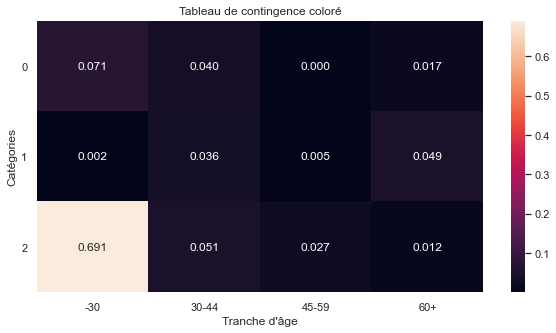

Le χ2 est de 125228.98
La P-value est de 0.000
Le degré de liberté est de 6


In [7]:
# Je réalise un tableau de contingence
tab_cont = pd.crosstab(df_principal['Catégories'].astype('int32'), df_principal.client_tranche_age, margins=True, margins_name='Total')

display(tab_cont)

# Que j'affiche sous forme de tableau coloré
tx = tab_cont.loc[:,["Total"]]
ty = tab_cont.loc[["Total"],:]
n = len(df_principal)
indep = tx.dot(ty) / n
c = tab_cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

plt.figure(figsize=(10,5))
sns.heatmap(table.iloc[:-1,:-1], annot=True, fmt='.3f')
plt.title("Tableau de contingence coloré")
plt.savefig('Graphiques/khi2_age_client_cat_produit.png') # J'enregistre le graphique
plt.xlabel('Tranche d\'âge')
plt.yticks(rotation=0)
plt.show()

# Je calcule le Khi2
chi2, p, dof, expected = st.chi2_contingency(tab_cont.iloc[:-1,:-1])

print(f'Le χ2 est de {chi2:.2f}')
print(f'La P-value est de {p:.3f}')
print(f'Le degré de liberté est de {dof}')


La comparaison entre notre χ2 calculé et le χ2 théorique nous permet de trancher entre les deux hypothèses.   
Pour α=5% : L'âge des clients a une incidence sur la catégorie des produits achetés. C'est l'hypothèse alternative ($H_1$) qui l'emporte.  

Source utilisée : https://archimede.mat.ulaval.ca/stt1920/STT-1920-Loi-du-khi-deux.pdf et http://aristeri.com/pages/statistiques/test_khi2/fiche_khi2.pdf